# Load CSDI

In [109]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
import sys
sys.path.append(r"C:\Users\vasil\Desktop\AstroInformatics\Compare_Models\CSDI_spectra_imputation_files")

import torch
from CSDI_spectra_imputation_files.main_model_spectra import CSDI_spectra
import yaml

def load_config(file_path):
    with open(file_path, 'r') as file:
        config = yaml.safe_load(file)
    return config

config = load_config("CSDI_spectra_imputation_files/base_spectra.yaml")
# Path to saved model
model_path = "CSDI_spectra_imputation_files/output_samples/model.pth"

# Load configuration and device
# config = torch.load("CSDI_spectra_imputation_files/base_spectra.yaml")  # If you saved the config
device = torch.device("cuda" if torch.cuda.is_available() else "cpu")

# Load model
model = CSDI_spectra(config, device)
model.load_state_dict(torch.load(model_path))
model.to(device)
model.eval()


C:\Users\vasil\AppData\Local\Temp\ipykernel_19672\33672436.py:27: FutureWarning: You are using `torch.load` with `weights_only=False` (the current default value), which uses the default pickle module implicitly. It is possible to construct malicious pickle data which will execute arbitrary code during unpickling (See https://github.com/pytorch/pytorch/blob/main/SECURITY.md#untrusted-models for more details). In a future release, the default value for `weights_only` will be flipped to `True`. This limits the functions that could be executed during unpickling. Arbitrary objects will no longer be allowed to be loaded via this mode unless they are explicitly allowlisted by the user via `torch.serialization.add_safe_globals`. We recommend you start setting `weights_only=True` for any use case where you don't have full control of the loaded file. Please open an issue on GitHub for any issues related to this experimental feature.
  model.load_state_dict(torch.load(model_path))


CSDI_spectra(
  (embed_layer): Embedding(1, 1)
  (diffmodel): diff_CSDI(
    (diffusion_embedding): DiffusionEmbedding(
      (projection1): Linear(in_features=128, out_features=128, bias=True)
      (projection2): Linear(in_features=128, out_features=128, bias=True)
      (dropout): Dropout(p=0.3, inplace=False)
    )
    (dropout): Dropout(p=0.2, inplace=False)
    (input_projection): Conv1d(2, 128, kernel_size=(1,), stride=(1,))
    (output_projection1): Conv1d(128, 128, kernel_size=(1,), stride=(1,))
    (output_projection2): Conv1d(128, 1, kernel_size=(1,), stride=(1,))
    (linear_layer1): Linear(in_features=128, out_features=128, bias=True)
    (linear_layer2): Linear(in_features=128, out_features=128, bias=True)
    (linear_layer3): Linear(in_features=128, out_features=128, bias=True)
    (residual_layers): ModuleList(
      (0-5): 6 x ResidualBlock(
        (diffusion_projection): Linear(in_features=128, out_features=128, bias=True)
        (cond_projection): Conv1d(66, 256, k

In [110]:
import pandas as pd
import numpy as np
import torch
import matplotlib.pyplot as plt
from spectra_dataset import get_dataloader, df_concat, spectra_Dataset
# loading data
wavelength_range = "ir"

df_cond = pd.read_csv("../data/interpolated_spectra.csv") # 10000 x 20
df_interpol = pd.read_csv("../data/spectra.csv") # 10000 x 223 

# focus only on the ir range (128 points) or the entire spectrum (243 points)
if wavelength_range == "ir":
    df_interpol_ir = df_interpol.iloc[:,66:66+108] # 10000 x 108 (66:66+108 yields points in 5-35 mu meter range)
    df_tot, cond_mask = df_concat(df_cond = df_cond, df_imp = df_interpol_ir) # 10000 x 128, 10000 x 128
    fluxes_np = np.log10(df_tot.values)
elif wavelength_range == "all":
    df_tot, cond_mask = df_concat(df_cond = df_cond, df_imp = df_interpol) # 10000 x 243, 10000 x 243
    fluxes_np = df_tot.values

sorted_wavelengths = df_tot.columns.values.astype(float)

fluxes_np.shape, sorted_wavelengths.shape, cond_mask.shape

C:\Users\vasil\AppData\Local\Temp\ipykernel_19672\1504280709.py:16: RuntimeWarning: invalid value encountered in log10
  fluxes_np = np.log10(df_tot.values)


((10000, 125), (125,), (10000, 125))

In [111]:
fluxes_np[0,:]

array([-0.06988702, -0.03639983, -0.00977699,  0.00337571,  0.03536585,
        0.05619702,  0.05928056,  0.05942273,  0.06406987,  0.07197055,
        0.08038287,  0.08254556,  0.08962517,  0.09910605,  0.10459963,
        0.10859803,  0.11928361,  0.13245914,  0.13781352,  0.14554703,
        0.15963342,  0.17246394,  0.17378498,  0.19088833,  0.21502214,
        0.2222518 ,  0.23696404,  0.26087059,  0.28561797,  0.30157881,
        0.30421226,  0.32618609,  0.34069383,  0.34733359,  0.35057183,
        0.35468002,  0.35637417,  0.35885228,  0.3613673 ,  0.36652904,
        0.37465774,  0.39154202,  0.40606238,  0.41460148,  0.41981302,
        0.42306606,  0.42570645,  0.42743336,  0.43200727,  0.43536053,
        0.43959408,  0.44589581,  0.44987849,  0.44967005,  0.44889287,
        0.45050094,  0.45343195,  0.45549088,  0.45860187,  0.45857251,
        0.45968373,  0.46135843,  0.46524085,  0.46648145,  0.46684714,
        0.46552784,  0.46318209,  0.46281998,  0.46128939,  0.46

In [112]:
import numpy as np
import torch
from CSDI_spectra_imputation_files.spectra_dataset import spectra_Dataset


# Reshape to [N, K, L]
# observed_data = fluxes_np[:, np.newaxis, :]  # Add feature dimension K=1
# cond_mask = cond_mask[:, np.newaxis, :]

# Create a Dataset object
test_dataset = spectra_Dataset(fluxes_np, cond_mask, eval_length=cond_mask.shape[-1], target_dim=1, mode="test")
test_loader = torch.utils.data.DataLoader(test_dataset, batch_size=32, shuffle=False)


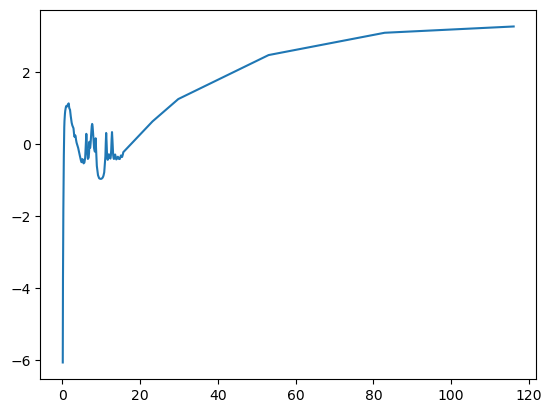

In [113]:
test = next(iter(test_loader))
plt.plot(sorted_wavelengths, test['observed_data'][1,0,:])

In [119]:
from CSDI_spectra_imputation_files.tools import eval_model

# Perform evaluation
num_samples = 10  # Number of imputations per sample to average
all_samples = eval_model(model, test_loader, num_samp=num_samples)

# Print or save outputs
# print("Imputed Samples Shape:", all_samples.shape)  # [N, L]
# print("Observed Data Shape:", all_observed_data.shape)  # [N, L]
all_samples[1]

array([[[        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-6.0693736 , -3.7598617 , -2.6437593 , ...,  2.4690895 ,
          3.0886738 ,  3.263114  ]],

       [[-3.3906922 , -3.240209  , -2.8135717 , ...,  2.935035  ,
          3.349484  ,  3.4667578 ]],

       ...,

       [[        nan,         nan,         nan, ...,         nan,
                 nan,         nan]],

       [[-3.9079242 , -3.223943  , -2.8097525 , ...,  0.5322064 ,
          0.25052992, -0.15028262]],

       [[-2.9408376 , -2.7260318 , -2.5549262 , ...,  0.38161615,
          0.00729015, -0.48359913]]], dtype=float32)

In [132]:
import matplotlib.pyplot as plt
from numpy import NaN
valid_spectra = sorted_wavelengths < 1
print(len(valid_spectra))
# if all_observed_data.shape[1] == 1:
    # all_observed_data = all_observed_data.squeeze(1)
# all_observed_data_filter = all_observed_data[valid_spectra]
# all_samples = all_samples.squeeze(1)
# Example: Plot observed vs imputed data for the first sample
# plt.plot(np.log10(sorted_wavelengths),all_observed_data[0], label="Observed Data", color="red")
sam = all_samples[0][0,0,:]

g = []
for val in sam:
    if val is NaN:
        print(val)
        g.append(val)

# plt.plot(sorted_wavelengths,val, label="Imputed Data", color="blue")
# plt.legend()
# plt.show()

# Save results
np.save("imputed_samples.npy", all_samples)


125
<class 'numpy.ndarray'>


In [118]:
all_samples[0][0,0,:]

array([nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan, nan,
       nan, nan, nan, nan, nan, nan, nan, nan], dtype=float32)